# Power Outage Data Analysis

**Name(s)**: Susana Haing, Sonali Singh

**Website Link**: (your website link)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import plotly.express as px
pd.options.plotting.backend = 'plotly'

import us 
from us import states

from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score



# from dsc80_utils import * # Feel free to uncomment and use this.

## Step 1: Introduction

In [2]:
# TODO

## Step 2: Data Cleaning and Exploratory Data Analysis

In [3]:
outage = pd.read_csv('outage.csv')

The original dataset comes with 57 total different variables, but we will focus only on the following columns for analysis and relevance sake.

In [4]:
working_outages = pd.read_csv('outage.csv', header=5)

columns_to_keep = [
    'YEAR', 'MONTH', 'U.S._STATE', 'NERC.REGION', 'CLIMATE.REGION',
    'OUTAGE.START.DATE', 'OUTAGE.START.TIME',
    'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME',
    'CAUSE.CATEGORY', 'CLIMATE.CATEGORY', 'OUTAGE.DURATION',
    'CUSTOMERS.AFFECTED', 'TOTAL.PRICE', 'TOTAL.SALES',
    'TOTAL.CUSTOMERS', 'POPDEN_URBAN'
]

outages_df = working_outages[columns_to_keep]


outages_df = outages_df[columns_to_keep]
outages_df = outages_df.drop(0)
outages_df = outages_df.reset_index(drop=True)

We chose to consolidate 'OUTAGE.START.DATE' and 'OUTAGE.START.TIME' and the 'OUTAGE.RESTORATION.DATE' and 'OUTAGE.RESTORATION.TIME' into just 'OUTAGE.DURATION' as we are most interested in the length of a power outage. We chose to include the start date and restoration date because there were some outages that lasted over multiple days, so including both the date and time made the most sense. 

In [5]:
outages_df['OUTAGE.START'] = pd.to_datetime(
    outages_df['OUTAGE.START.DATE'] + ' ' + outages_df['OUTAGE.START.TIME'],
    format='%A, %B %d, %Y %I:%M:%S %p'  
)

outages_df['OUTAGE.RESTORATION'] = pd.to_datetime(
    outages_df['OUTAGE.RESTORATION.DATE'] + ' ' + outages_df['OUTAGE.RESTORATION.TIME'],
    format='%A, %B %d, %Y %I:%M:%S %p'  )


In [6]:
outages_df = outages_df.drop(columns=[
    'OUTAGE.START.DATE', 
    'OUTAGE.START.TIME', 
    'OUTAGE.RESTORATION.DATE', 
    'OUTAGE.RESTORATION.TIME'
])

Here, in the 'OUTAGE.DURATION' and 'CUSTOMERS.AFFECTED' columns, we can see that there are some rows with 0 as its values, which doesn't make any sense as there is no power outage that lasted 0 minutes and affected 0 customers, so we changed it to np.nan values so they wouldn't skew the data.

In [7]:
outcome_columns = ['OUTAGE.DURATION', 'CUSTOMERS.AFFECTED']

outages_df[outcome_columns] = outages_df[outcome_columns].replace(0, np.nan)

In [8]:
outages_by_state = outages_df['U.S._STATE'].value_counts().reset_index()
outages_by_state.columns = ['STATE', 'OUTAGE_COUNT'] 

## Univariate Analysis

Now let's take a look at how the power outages are distributed across the 50 states. We can visualize this with a choropleth map, which will show by color, the number of power outages each state has and also show which states have the most and least number of power outages.

In [9]:
state_to_code = {state.name: state.abbr for state in states.STATES}
#print(state_to_code) 

outages_by_state['STATE_CODE'] = outages_by_state['STATE'].map(state_to_code)

# Verify
print(outages_by_state.head())

        STATE  OUTAGE_COUNT STATE_CODE
0  California           210         CA
1       Texas           127         TX
2  Washington            97         WA
3    Michigan            95         MI
4    New York            71         NY


In [10]:
fig = px.choropleth(
    outages_by_state,
    locations = 'STATE_CODE',     
    locationmode = 'USA-states',   
    color = 'OUTAGE_COUNT',        # Color by outage count
    scope = 'usa',             
    color_continuous_scale = 'sunset', 
    title = 'Power Outages by U.S. State',
    hover_name = 'STATE',  
    labels = {'OUTAGE_COUNT': 'Outages'}
)

fig.update_layout(
    geo = dict(bgcolor='rgba(0,0,0,0)'), 
    margin = {"r": 0, "t": 40, "l": 0, "b": 0}
)

fig.show()

Next, we wanted to see how the number of power outages have changed over time. 

In [11]:
outages_per_year = outages_df['YEAR'].value_counts().sort_index().reset_index()
outages_per_year.columns = ['Year', 'Number of Outages']

fig = px.line(outages_per_year, x = 'Year', y = 'Number of Outages', title = 'Power Outages Over Time')

fig.show()

We also wanted to see the number of power outages across the different climate regions. 

In [12]:
outages_by_region = outages_df['CLIMATE.REGION'].value_counts().reset_index()
outages_by_region.columns = ['Climate Region', 'Number of Outages']

fig = px.bar(outages_by_region, x = 'Climate Region', y = 'Number of Outages', title = 'Power Outages by Climate Region', color = 'Climate Region', text = 'Number of Outages')

fig.show()

## Bivariate Analysis

First, we wanted to take a look at how the 'OUTAGE.DURATIONS' were distributed across the different 'CLIMATE.REGION's.

In [13]:
fig = px.scatter(outages_df, x = 'CLIMATE.REGION', y = 'OUTAGE.DURATION', title = 'Outage Duration by Climate Region', color = 'CLIMATE.REGION')

fig.show()

note: add another bivariate analysis later

## Step 3: Assessment of Missingness

In [14]:
df = outages_df.copy()

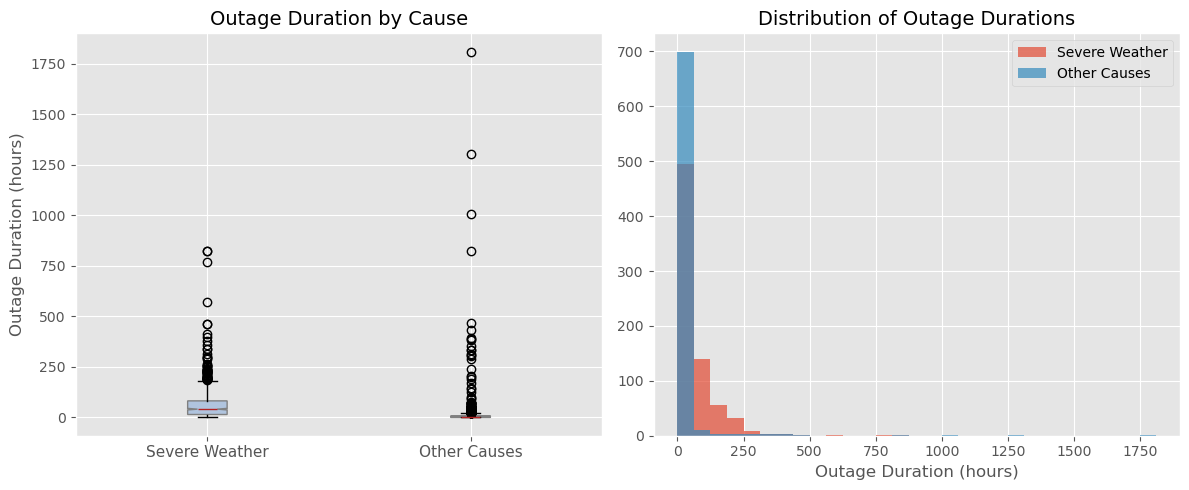

In [15]:
df['OUTAGE.DURATION'] = pd.to_numeric(
    df['OUTAGE.DURATION'], errors='coerce'
)

df['OUTAGE.DURATION_HOURS'] = df['OUTAGE.DURATION'] / 60

mask   = df['CAUSE.CATEGORY'] == 'severe weather'
severe = df.loc[mask,  'OUTAGE.DURATION_HOURS'].dropna()
other  = df.loc[~mask, 'OUTAGE.DURATION_HOURS'].dropna()

plt.style.use('ggplot')


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ─── Boxplot ───
axes[0].boxplot(
    [severe, other],
    notch=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightsteelblue', edgecolor='gray'),
    medianprops=dict(color='firebrick')
)
axes[0].set_xticklabels(['Severe Weather', 'Other Causes'], fontsize=11)
axes[0].set_ylabel('Outage Duration (hours)', fontsize=12)
axes[0].set_title('Outage Duration by Cause', fontsize=14)

# ─── Histogram ───
bins = np.linspace(0, df['OUTAGE.DURATION_HOURS'].max(), 30)
axes[1].hist(severe, bins=bins, alpha=0.7, label='Severe Weather')
axes[1].hist(other,  bins=bins, alpha=0.7, label='Other Causes')
axes[1].set_xlabel('Outage Duration (hours)', fontsize=12)
axes[1].set_title('Distribution of Outage Durations', fontsize=14)
axes[1].legend(fontsize=10)

# 7) Tidy up
plt.tight_layout()
plt.show()

# Hypothesis Recap
#   • Null (H₀): Severe‐weather outages have the same mean duration as all other outages.
#   • Alternative (H₁): Severe‐weather outages have a different mean duration than other outages.
#   • Test Statistic: Two‐sample t‐statistic on the difference of means (and we also examined the KS 
# statistic to compare full distributions).
#
# ──────────────────────────────────────────────────────────────────────────────
#
# Figure 1: Outage Duration by Cause (Boxplot)
#
# What you see: Two side-by-side notched boxplots—one for “Severe Weather” outages 
# and one for “Other Causes.” Each box shows the interquartile range (IQR), the 
# horizontal line is the median, and the notch gives a visual 95% CI around the median.
#
#   • Severe Weather: The median sits noticeably higher, with a wider IQR, indicating 
#     longer typical outages under severe‐weather events.
#   • Other Causes: A lower median and tighter IQR reflect generally shorter and more 
#     consistent outage lengths.
#   • Outliers: Both groups have extreme events (dots far above the whiskers), but 
#     the severe‐weather group reaches higher maximums.
#
# Interpretation: Because the box for “Severe Weather” is both shifted upward and 
# notched away from the “Other Causes” box, we have visual evidence that severe‐weather 
# outages tend to last longer on average—supporting rejection of H₀.
#
# ──────────────────────────────────────────────────────────────────────────────
#
# Figure 2: Distribution of Outage Durations (Histogram)
#
# What you see: Overlaid histograms for the two groups on the same bins (0–1,800 hours). 
# The red bars are severe‐weather durations, and the blue bars are other causes.
#
#   • Red curve (Severe Weather): A right-shifted peak around ~50–100 hours with a long 
#     tail extending beyond 500 hours.
#   • Blue curve (Other Causes): A sharper spike near 20–40 hours and a very thin tail, 
#     indicating most outages are short.
#
# Interpretation: The severe‐weather histogram is clearly shifted to the right and has 
# heavier tails—further confirming that outages during severe weather are both longer 
# and more variable than those from other causes.
#
# ──────────────────────────────────────────────────────────────────────────────
#
# Together, these two figures—boxplot and histogram—provide both a summary (medians/IQRs) 
# and a full‐distribution view, each reinforcing our finding that severe‐weather outages 
# last significantly longer than other outages.



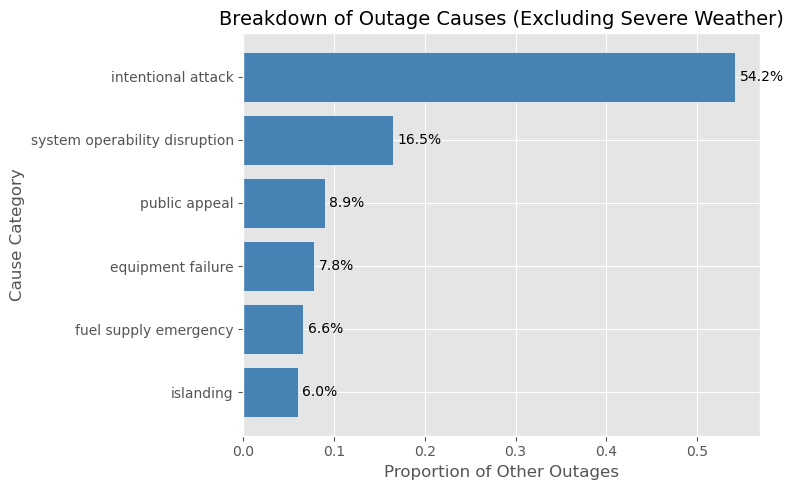

In [16]:
others = df.loc[
    df['CAUSE.CATEGORY'] != 'severe weather',
    'CAUSE.CATEGORY'
]

# 3) Compute the relative frequency of each remaining cause
prop_other = others.value_counts(normalize=True).sort_values()

# 4) Plot a horizontal bar chart using Matplotlib
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(prop_other.index, prop_other.values, color='steelblue', edgecolor='white')

# 5) Add axis labels and a title
ax.set_xlabel('Proportion of Other Outages', fontsize=12)
ax.set_ylabel('Cause Category', fontsize=12)
ax.set_title('Breakdown of Outage Causes (Excluding Severe Weather)', fontsize=14)

# 6) Annotate each bar with its percentage
for i, pct in enumerate(prop_other.values):
    ax.text(pct + 0.005, i, f"{pct:.1%}", va='center', fontsize=10)

plt.tight_layout()
plt.show()


# The above code reads your outage data, filters out “severe weather,” 
# computes the share of each remaining cause, and displays a horizontal 
# bar chart with percentage labels:
#   • Intentional attack accounts for over 50% of the non-severe‐weather outages.
#   • System operability disruption is next at ~16%.
#   • The smaller slices (<10%) are public appeal, equipment failure, 
#     fuel supply emergency, and islanding.
#
# Feel free to embed this figure with a caption like:
#
#   Figure: Breakdown of outage causes (excluding severe weather). 
#   “Intentional attack” is the largest category, making up 54.2% of these outages.

## Step 4: Hypothesis Testing

We will be testing if the 'CAUSE.CATEGORY' has an affect on the length of a power outages. In particular, we will be testing if Severe Weather has an affect, and if it doesn't, we will test which 'CAUSE.CATEGORY' does have an affect.

**Null Hypothesis:** Severe weather has no effect on the length of a power outage.

**Alternative Hypothesis:** Severe weather has an effect on the length of a power outage (either causing a shorter or longer poewr outage).

In [17]:
hypothesis_df = outages_df.copy()
hypothesis_df['OUTAGE.DURATION'] = pd.to_numeric(
    hypothesis_df['OUTAGE.DURATION'], errors='coerce'
)

hypothesis_df.head()

,YEAR,MONTH,U.S._STATE,NERC.REGION,CLIMATE.REGION,CAUSE.CATEGORY,CLIMATE.CATEGORY,OUTAGE.DURATION,CUSTOMERS.AFFECTED,TOTAL.PRICE,TOTAL.SALES,TOTAL.CUSTOMERS,POPDEN_URBAN,OUTAGE.START,OUTAGE.RESTORATION
0,2011.0,7.0,Minnesota,MRO,East North Central,severe weather,normal,3060.0,70000.0,9.28,6562520,2595696.0,2279,2011-07-01 17:00:00,2011-07-03 20:00:00
1,2014.0,5.0,Minnesota,MRO,East North Central,intentional attack,normal,1.0,NaN,9.28,5284231,2640737.0,2279,2014-05-11 18:38:00,2014-05-11 18:39:00
2,2010.0,10.0,Minnesota,MRO,East North Central,severe weather,cold,3000.0,70000.0,8.15,5222116,2586905.0,2279,2010-10-26 20:00:00,2010-10-28 22:00:00
3,2012.0,6.0,Minnesota,MRO,East North Central,severe weather,normal,2550.0,68200.0,9.19,5787064,2606813.0,2279,2012-06-19 04:30:00,2012-06-20 23:00:00
4,2015.0,7.0,Minnesota,MRO,East North Central,severe weather,warm,1740.0,250000.0,10.43,5970339,2673531.0,2279,2015-07-18 02:00:00,2015-07-19 07:00:00


# Permutation Test

In [18]:
severe_weather = hypothesis_df[hypothesis_df['CAUSE.CATEGORY'] == 'severe weather']['OUTAGE.DURATION']
non_severe = hypothesis_df[hypothesis_df['CAUSE.CATEGORY'] != 'severe weather']['OUTAGE.DURATION']

severe_weather = severe_weather.dropna()
non_severe = non_severe.dropna()


observed_diff = severe_weather.mean() - non_severe.mean()
print(f"Observed Difference (Severe - Non Severe): {observed_diff:.2f} minutes")

Observed Difference (Severe - Non Severe): 2537.81 minutes


In [19]:
combined = np.concatenate([severe, non_severe])
n_perm = 10000
perm_diffs = np.zeros(n_perm)

for i in range(n_perm):
    shuffled = np.random.permutation(combined)
    perm_diffs[i] = shuffled[:len(severe)].mean() - shuffled[len(severe):].mean()

p_val = (np.abs(perm_diffs) >= np.abs(observed_diff)).mean()

print(f"Observed difference: {observed_diff:.2f} minutes")
print(f"Permutation p-value: {p_val:.4f}")
print(f"Conclusion: {'REJECT' if p_val < 0.05 else 'DO NOT REJECT'} null hypothesis")
print(f"Severe weather {'does' if p_val < 0.05 else 'does NOT'} significantly affect outage duration")

Observed difference: 2537.81 minutes
Permutation p-value: 0.0000
Conclusion: REJECT null hypothesis
Severe weather does significantly affect outage duration


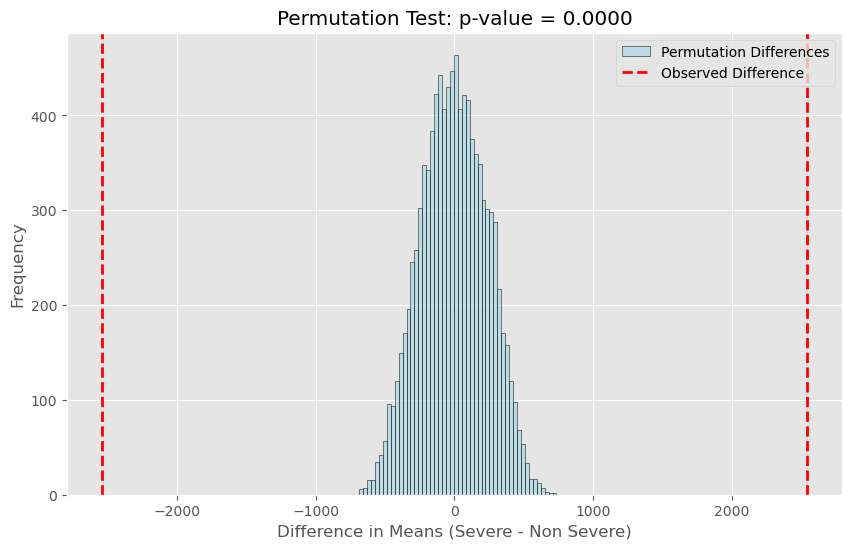

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(perm_diffs, bins=50, edgecolor='k', alpha=0.7, label='Permutation Differences', color ='lightblue')
plt.axvline(observed_diff, color='red', linestyle='--', linewidth=2, label='Observed Difference')
plt.axvline(-observed_diff, color='red', linestyle='--', linewidth=2)  
plt.xlabel('Difference in Means (Severe - Non Severe)')
plt.ylabel('Frequency')
plt.title(f'Permutation Test: p-value = {p_val:.4f}')
plt.legend()
plt.show()

## Step 5: Framing a Prediction Problem

Our model will attempt to predict the length of a power outage duration in a regression model. 

The metric we plan to use to evaluate the model is the Mean Absolute Error as we will be able to see how the average prediction error in minutes. 

At the time of prediction,we will know the Cause Category, NERC Region, Climate Category, Month, Year, and US State. 

## Step 6: Baseline Model

In [21]:
features = ['NERC.REGION', 'CLIMATE.REGION', 'CAUSE.CATEGORY', 'U.S._STATE', 'MONTH', 'YEAR']
target = 'OUTAGE.DURATION'

In [22]:
categorical_cols = ['CAUSE.CATEGORY', 'NERC.REGION', 'CLIMATE.CATEGORY', 'U.S._STATE']
numerical_cols = ['MONTH', 'YEAR']  

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)

preprocessor

ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['CAUSE.CATEGORY', 'NERC.REGION',
                                  'CLIMATE.CATEGORY', 'U.S._STATE']),
                                ('num', StandardScaler(), ['MONTH', 'YEAR'])])

In [23]:
pl = Pipeline([
    ('preprocessor', preprocessor), 
    ('lin-reg', LinearRegression())
])

pl

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CAUSE.CATEGORY',
                                                   'NERC.REGION',
                                                   'CLIMATE.CATEGORY',
                                                   'U.S._STATE']),
                                                 ('num', StandardScaler(),
                                                  ['MONTH', 'YEAR'])])),
                ('lin-reg', LinearRegression())])

In [ ]:
clean_df = outages_df.dropna(subset=[target] + features)
x = clean_df[features]
y = clean_df[target]

model_with_std = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),  
    LinearRegression()
)
model_with_std.fit(x, y)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('linearregression', LinearRegression())])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [26]:
model_with_std.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('linearregression', LinearRegression())])

In [27]:
y_pred = model_with_std.predict(X_test)

print("=== Evaluation Metrics ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} minutes")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.2f} minutes")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

=== Evaluation Metrics ===
MAE: 2823.25 minutes
RMSE: 7388.26 minutes
R²: 0.1081


## Step 7: Final Model

In [ ]:
# TODO

## Step 8: Fairness Analysis

In [ ]:
# TODO